# Title: Office 365 Explorer
**Notebook Version:** 1.0<br>
**Python Version:** Python 3.6 (including Python 3.6 - AzureML)<br>
**Required Packages**: kqlmagic, msticpy, pandas, numpy, matplotlib, seaborn, networkx, ipywidgets, ipython, scikit_learn, folium, maxminddb_geolite2, holoviews<br>
**Platforms Supported**:
- Azure Notebooks Free Compute
- Azure Notebooks DSVM
- OS Independent

**Data Sources Required**:
- Log Analytics - OfficeActivity, IPLocation, Azure Network Analytics

## Description:
Brings together a series of queries and visualizations to help you investigate the security status of Office 365 subscription and individual user activities.
- The first section focuses on Tenant-Wide data queries and analysis
- The second section allows you to focus on individial accounts and examine them for any suspicious activity.

This notebook is intended to be illustrative of the types of data available in Office 365 Activity data and how to query and use them. It is not meant to be used as a prescriptive guide to how to navigate through the data. Feel free to experiment and submit anything interesting you find to the community.



<a id="contents"></a>
# Table of Contents
- [Setup and Authenticate](#setup)
- [Office 365 Activity](#o365)
  - [Tenant-wide Information](#tenant_info)
    - [AAD Operations - Account Modifications](#aad_ops)
    - [Logon Anomalies](#logon_anomalies)
    - [Activity Summary](#activity_summary)
    - [Variability of IP Address for users](#ip_variability)
    - [Accounts with multiple IPs and Geolocations](#acct_multi_geo)
    - [User Logons with > N IP Address](#acct_multi_ips)
    - [Operation Types by Location and IP](#ip_op_matrix)
    - [Geolocation Map of Client IPs](#geo_map_tenant)
    - [Distinct User Agent Strings in Use](#distinct_uas)
    - [Graphical Activity Timeline](#op_timeline)
    - [Users With largest Activity Type Count](#user_activity_counts)
  - [Office User Investigation](#o365_user_inv)
    - [Activity Summary](#user_act_summary)
    - [Operation Breakdown for User](#user_op_count)
    - [IP Count for Different User Operations](#user_ip_counts)
    - [Activity Timeline](#user_act_timeline)
    - [User IP GeoMap](#user_geomap)
    - [Check for User IPs in Azure Network Flow Data](#ips_in_azure)
  - [Rare Combinations of Country/UserAgent/Operation Type](#o365_cluster)
- [Appendices](#appendices)
  - [Saving data to Excel](#appendices)


<a id='setup'></a>[Contents](#contents)
# Setup

Make sure that you have installed packages specified in the setup (uncomment the lines to execute)

## Install Packages
The first time this cell runs for a new Azure Notebooks project or local Python environment it will take several minutes to download and install the packages. In subsequent runs it should run quickly and confirm that package dependencies are already installed. Unless you want to upgrade the packages you can feel free to skip execution of the next cell.

If you see any import failures (```ImportError```) in the notebook, please re-run this cell and answer 'y', then re-run the cell where the failure occurred.

Note you may see some warnings about package incompatibility with certain packages. This does not affect the functionality of this notebook but you may need to upgrade the packages producing the warnings to a more recent version.

In [49]:
import sys
import warnings

warnings.filterwarnings("ignore",category=DeprecationWarning)

MIN_REQ_PYTHON = (3,6)
if sys.version_info < MIN_REQ_PYTHON:
    print('Check the Kernel->Change Kernel menu and ensure that Python 3.6')
    print('or later is selected as the active kernel.')
    sys.exit("Python %s.%s or later is required.\n" % MIN_REQ_PYTHON)

# Package Installs - try to avoid if they are already installed
try:
    import msticpy
    import Kqlmagic
    from dns import reversename, resolver
    from ipwhois import IPWhois
    import folium
    
    print('If you answer "n" this cell will exit with an error in order to avoid the pip install calls,')
    print('This error can safely be ignored.')
    resp = input('msticpy and Kqlmagic packages are already loaded. Do you want to re-install? (y/n)')
    if resp.strip().lower() != 'y':
        sys.exit('pip install aborted - you may skip this error and continue.')
    else:
        print('After installation has completed, restart the current kernel and run '
              'the notebook again skipping this cell.')
except ImportError:
    pass

print('\nPlease wait. Installing required packages. This may take a few minutes...')
!pip install git+https://github.com/microsoft/msticpy@iputils --upgrade --user
!pip install Kqlmagic --no-cache-dir --upgrade --user
!pip install seaborn --upgrade --user
!pip install holoviews --upgrade --user
!pip install dnspython --upgrade --user 
!pip install ipwhois --upgrade --user 
!pip install folium --upgrade --user

# Uncomment to refresh the maxminddb database
# !pip install maxminddb-geolite2 --upgrade 

print('To ensure that the latest versions of the installed libraries '
      'are used, please restart the current kernel and run '
      'the notebook again skipping this cell.')

If you answer "n" this cell will exit with an error in order to avoid the pip install calls,
This error can safely be ignored.
msticpy and Kqlmagic packages are already loaded. Do you want to re-install? (y/n)n


SystemExit: pip install aborted - you may skip this error and continue.

C:\Users\ianhelle\AppData\Local\Continuum\anaconda3\envs\condadev\lib\site-packages\IPython\core\interactiveshell.py:3334: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



In [1]:
# Imports
import sys
import warnings

MIN_REQ_PYTHON = (3,6)
if sys.version_info < MIN_REQ_PYTHON:
    print('Check the Kernel->Change Kernel menu and ensure that Python 3.6')
    print('or later is selected as the active kernel.')
    sys.exit("Python %s.%s or later is required.\n" % MIN_REQ_PYTHON)

import numpy as np
from IPython import get_ipython
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import networkx as nx

import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)

from msticpy.sectools import *
from msticpy.nbtools import *
import msticpy.sectools as sectools


# Some of our dependencies (networkx) still use deprecated Matplotlib
# APIs - we can't do anything about it so suppress them from view
from matplotlib import MatplotlibDeprecationWarning
warnings.simplefilter("ignore", category=MatplotlibDeprecationWarning)

WIDGET_DEFAULTS = {'layout': widgets.Layout(width='95%'),
                   'style': {'description_width': 'initial'}}


Using Open PageRank. See https://www.domcop.com/openpagerank/what-is-openpagerank


### Get WorkspaceId
To find your Workspace Id go to [Log Analytics](https://ms.portal.azure.com/#blade/HubsExtension/Resources/resourceType/Microsoft.OperationalInsights%2Fworkspaces). Look at the workspace properties to find the ID.

In [2]:
import os
from msticpy.nbtools.wsconfig import WorkspaceConfig
ws_config_file = 'config.json'

WORKSPACE_ID = None
TENANT_ID = None
try:
    ws_config = WorkspaceConfig(ws_config_file)
    display(Markdown(f'Read Workspace configuration from local config.json for workspace **{ws_config["workspace_name"]}**'))
    for cf_item in ['tenant_id', 'subscription_id', 'resource_group', 'workspace_id', 'workspace_name']:
        display(Markdown(f'**{cf_item.upper()}**: {ws_config[cf_item]}'))
                     
    if ('cookiecutter' not in ws_config['workspace_id'] or
            'cookiecutter' not in ws_config['tenant_id']):
        WORKSPACE_ID = ws_config['workspace_id']
        TENANT_ID = ws_config['tenant_id']
except:
    pass

if not WORKSPACE_ID or not TENANT_ID:
    display(Markdown('**Workspace configuration not found.**\n\n'
                     'Please go to your Log Analytics workspace, copy the workspace ID'
                     ' and/or tenant Id and paste here.<br> '
                     'Or read the workspace_id from the config.json in your Azure Notebooks project.'))
    ws_config = None
    ws_id = mas.GetEnvironmentKey(env_var='WORKSPACE_ID',
                              prompt='Please enter your Log Analytics Workspace Id:', auto_display=True)
    ten_id = mas.GetEnvironmentKey(env_var='TENANT_ID',
                              prompt='Please enter your Log Analytics Tenant Id:', auto_display=True)

Read Workspace configuration from local config.json for workspace **ASIHuntOMSWorkspaceV4**

**TENANT_ID**: 72f988bf-86f1-41af-91ab-2d7cd011db47

**SUBSCRIPTION_ID**: 40dcc8bf-0478-4f3b-b275-ed0a94f2c013

**RESOURCE_GROUP**: ASIHuntOMSWorkspaceRG

**WORKSPACE_ID**: 52b1ab41-869e-4138-9e40-2a4457f09bf0

**WORKSPACE_NAME**: ASIHuntOMSWorkspaceV4

### Authenticate to Log Analytics
If you are using user/device authentication, run the following cell. 
- Click the 'Copy code to clipboard and authenticate' button.
- This will pop up an Azure Active Directory authentication dialog (in a new tab or browser window). The device code will have been copied to the clipboard. 
- Select the text box and paste (Ctrl-V/Cmd-V) the copied value. 
- You should then be redirected to a user authentication page where you should authenticate with a user account that has permission to query your Log Analytics workspace.

Use the following syntax if you are authenticating using an Azure Active Directory AppId and Secret:
```
%kql loganalytics://tenant(aad_tenant).workspace(WORKSPACE_ID).clientid(client_id).clientsecret(client_secret)
```
instead of
```
%kql loganalytics://code().workspace(WORKSPACE_ID)
```

Note: you may occasionally see a JavaScript error displayed at the end of the authentication - you can safely ignore this.<br>
On successful authentication you should see a ```popup schema``` button.

In [5]:
if not WORKSPACE_ID or not TENANT_ID:
    try:
        WORKSPACE_ID = ws_id.value
        TENANT_ID = ten_id.value
    except NameError:
        raise ValueError('No workspace or Tenant Id.')

from msticpy.data import QueryProvider
qry_prov = QueryProvider("LogAnalytics")
%kql loganalytics://code().tenant(TENANT_ID).workspace(WORKSPACE_ID)
qry_prov.connect(connection_str=ws_config.code_connect_str)
table_index = qry_prov.schema_tables

<a id='o365'></a>[Contents](#contents)
# Office 365 Activity

### Log Analytics Queries

In [7]:
if 'OfficeActivity' not in table_index:
    display(Markdown('<font color="red"><h2>Warning. Office Data not available.</h2></font><br>'
                     'Either Office 365 data has not been imported into the workspace or'
                     ' the OfficeActivity table is empty.<br>'
                     'This workbook is not useable with the current workspace.'))

In [8]:
from msticpy.sectools.geoip import GeoLiteLookup
iplocation = GeoLiteLookup()

# Queries
office_ops_query = '''
OfficeActivity
| where TimeGenerated >= datetime({start})
| where TimeGenerated <= datetime({end})
| where RecordType in ("AzureActiveDirectoryAccountLogon", "AzureActiveDirectoryStsLogon")
| extend UserAgent = extractjson("$[0].Value", ExtendedProperties, typeof(string))
| union (
    OfficeActivity 
    | where TimeGenerated >= datetime({start})
    | where TimeGenerated <= datetime({end})
    | where RecordType !in ("AzureActiveDirectoryAccountLogon", "AzureActiveDirectoryStsLogon")
)
| where UserType == 'Regular'
'''


office_ops_summary_query = '''
let officeAuthentications = OfficeActivity
| where TimeGenerated >= datetime({start})
| where TimeGenerated <= datetime({end})
| where RecordType in ("AzureActiveDirectoryAccountLogon", "AzureActiveDirectoryStsLogon")
| extend UserAgent = extractjson("$[0].Value", ExtendedProperties, typeof(string))
| where Operation == "UserLoggedIn";
officeAuthentications
| union (
    OfficeActivity 
    | where TimeGenerated >= datetime({start})
    | where TimeGenerated <= datetime({end})
    | where RecordType !in ("AzureActiveDirectoryAccountLogon", "AzureActiveDirectoryStsLogon")
)
| where UserType == 'Regular'
| extend RecordOp = strcat(RecordType, '-', Operation)
| summarize OperationCount=count() by RecordType, Operation, UserId, UserAgent, ClientIP, bin(TimeGenerated, 1h)
// render timeline
'''


office_logons_byua_query = '''
let end = datetime({end});
let threshold={threshold};
let start = end - 1d;
let hist_start = start - 30d;
let hist_end = end;
let officeAuthentications = OfficeActivity
| where TimeGenerated >= hist_start
| where TimeGenerated <= hist_end
| where RecordType in ("AzureActiveDirectoryAccountLogon", "AzureActiveDirectoryStsLogon")
| extend UserAgent = extractjson("$[0].Value", ExtendedProperties, typeof(string))
| where Operation == "UserLoggedIn";
let lookupWindow = end - start;
let lookupBin = lookupWindow / 2.0; 
officeAuthentications 
| project-rename Start = TimeGenerated
| extend TimeKey = bin(Start, lookupBin)
| join kind = inner (
    officeAuthentications
    | project-rename End = TimeGenerated
    | extend TimeKey = range(bin(End - lookupWindow, lookupBin), bin(End, lookupBin), lookupBin)
    | mvexpand TimeKey to typeof(datetime)
) on UserAgent, TimeKey
| project timeSpan = End - Start, UserId, ClientIP , UserAgent , Start, End
| summarize Count_ClientIP = dcount(ClientIP) by UserId
| where Count_ClientIP > threshold
| join kind=inner (  
    officeAuthentications
    | summarize minTime=min(TimeGenerated), maxTime=max(TimeGenerated) by UserId, UserAgent, ClientIP
) on UserAgent
'''


In [12]:
# set the origin time to the time of our alert
o365_query_times = nbwidgets.QueryTime(units='hours',
                           before=24, after=1, max_before=120, max_after=20)
o365_query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

<a id='tenant_info'></a>[Contents](#contents)
## Tenant-wide Information

<a id='activity_summary'></a>[Contents](#contents)
### Summary of O365 Activity Types
#### <font color="red">Warning this query can be time consuming for large O365 subscriptions</font>

In [13]:
print('Getting data...', end=' ')
o365_query = office_ops_summary_query.format(start = o365_query_times.start, 
                                             end=o365_query_times.end)
%kql -query o365_query
office_ops_summary_df = _kql_raw_result_.to_dataframe()
print('done.')
(office_ops_summary_df
 .assign(UserId = lambda x: x.UserId.str.lower())
 .groupby(['RecordType', 'Operation'])
 .aggregate({'ClientIP': 'nunique',
             'UserId': 'nunique',
             'OperationCount': 'sum'}))

Getting data... done.


ClientIP  UserId  OperationCount
RecordType        Operation                                           
ExchangeItem      Create                     3      21              28
                  MailboxLogin               3       3               5
ExchangeItemGroup MoveToDeletedItems         3       1               6

<a id='ip_variability'></a>[Contents](#contents)
### Variability of IP Address for users

Variability of IP Address Usage by user

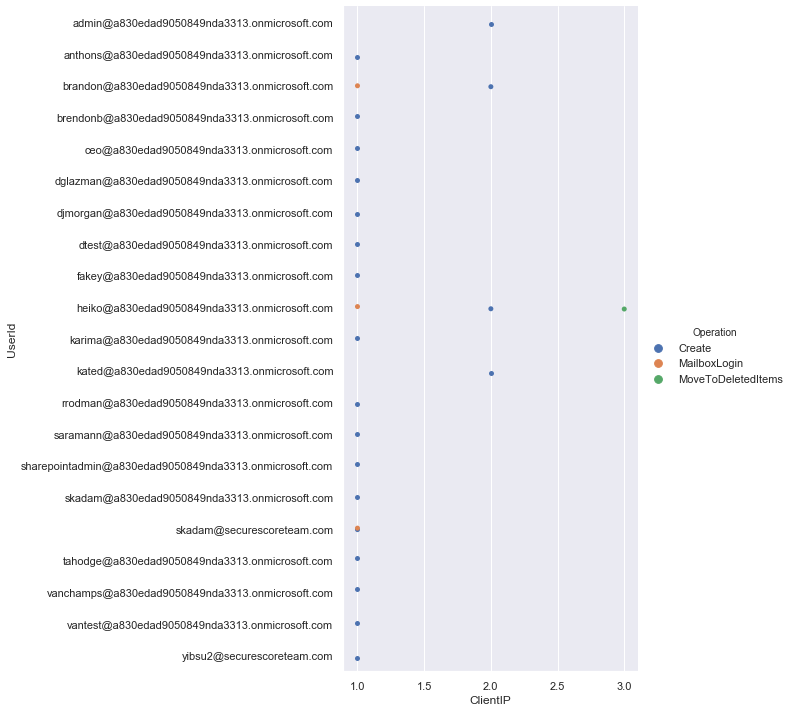

In [14]:
unique_ip_op_ua = (office_ops_summary_df.assign(UserId = lambda x: x.UserId.str.lower())
                   .groupby(['UserId', 'Operation'])
                   .aggregate({'ClientIP': 'nunique', 'OperationCount': 'sum'})).reset_index()

user_ip_op = sns.catplot(x="ClientIP", y="UserId", hue='Operation', data=unique_ip_op_ua, height=10, aspect=1)
display(Markdown('Variability of IP Address Usage by user'))

<a id='acct_multi_geo'></a>[Contents](#contents)
### Accounts with multiple IPs and Geolocations

In [15]:
restrict_cols = ['RecordType', 'TimeGenerated', 'Operation',
                 'UserId', 'ClientIP', 'UserAgent']
office_ops_summary = office_ops_summary_df[restrict_cols].assign(UserId = lambda x: x.UserId.str.lower())
unique_ip_op_ua['ClientIPCount'] = unique_ip_op_ua['ClientIP']
office_ops_merged = pd.merge(unique_ip_op_ua.query('ClientIP > 1').drop(columns='ClientIP'), 
                             office_ops_summary,
                             on=['UserId', 'Operation'])


client_ips = office_ops_merged.query('ClientIP != "<null>" & ClientIP != ""')['ClientIP'].drop_duplicates().tolist()
ip_entities = []
for ip in client_ips:
    ip_entity = entities.IpAddress(Address=ip)
    iplocation.lookup_ip(ip_entity=ip_entity)
    if ip_entity.Location:
        ip_dict = {'Address': ip_entity.Address}
        ip_dict.update(ip_entity.Location.properties)
        ip_entities.append(pd.Series(ip_dict))

ip_locs_df = pd.DataFrame(data=ip_entities)
ip_locs_df

office_ops_summary_ip_loc = pd.merge(office_ops_merged, 
                                     ip_locs_df, left_on='ClientIP', 
                                     right_on='Address', how='left')

(office_ops_summary_ip_loc.groupby(['UserId', 'CountryCode', 'City'])
                   .aggregate({'ClientIP': 'nunique', 'OperationCount': 'sum'})).reset_index()

,UserId,CountryCode,City,ClientIP,OperationCount
0,admin@a830edad9050849nda3313.onmicrosoft.com,US,Washington,2,4
1,brandon@a830edad9050849nda3313.onmicrosoft.com,US,Washington,2,4
2,heiko@a830edad9050849nda3313.onmicrosoft.com,US,Redmond,2,18
3,heiko@a830edad9050849nda3313.onmicrosoft.com,US,San Francisco,1,6
4,heiko@a830edad9050849nda3313.onmicrosoft.com,US,Washington,1,10
5,kated@a830edad9050849nda3313.onmicrosoft.com,US,Washington,1,2


# @ Charu - example of simple query

In [ ]:
%%kql
OfficeActivity
| where TimeGenerated > ago(300d)
| project-away UserKey, OfficeId
| limit 100

<a id='acct_multi_ips'></a>[Contents](#contents)
### User Logons where User has logged on from > N IP Address in period

In [16]:
th_wgt = widgets.IntSlider(value=1, min=1, max=50, step=1, description='Set IP Count Threshold', **WIDGET_DEFAULTS)
th_wgt

IntSlider(value=1, description='Set IP Count Threshold', layout=Layout(width='95%'), max=50, min=1, style=Slid…

<a id='ip_op_matrix'></a>[Contents](#contents)
### Matrix of Selected Operation Types by Location and IP

In [26]:
print('Getting data...', end=' ')
o365_query = office_ops_query.format(start=o365_query_times.start, 
                                     end=o365_query_times.end)
%kql -query o365_query
office_ops_df = _kql_raw_result_.to_dataframe()
print('done.') 

# Get Locations for distinct IPs
# client_ips = office_ops_df.query('ClientIP != "<null>" & ClientIP != ""')['ClientIP'].drop_duplicates().tolist()
# ip_entities = []
# for ip in client_ips:
#     ip_entity = mas.IpAddress(Address=ip)
#     iplocation.lookup_ip(ip_entity=ip_entity)
#     ip_dict = {'Address': ip_entity.Address}
#     ip_dict.update(ip_entity.Location.properties)
#     ip_entities.append(pd.Series(ip_dict))
client_ips = office_ops_df.query('ClientIP != "<null>" & ClientIP != ""')['ClientIP'].drop_duplicates().tolist()
ip_entities = []
for ip in client_ips:
    ip_entity = entities.IpAddress(Address=ip)
    iplocation.lookup_ip(ip_entity=ip_entity)
    if ip_entity.Location:
        ip_dict = {'Address': ip_entity.Address}
        ip_dict.update(ip_entity.Location.properties)
        ip_entities.append(pd.Series(ip_dict))

ip_locs_df = pd.DataFrame(data=ip_entities)

# Get rid of unneeded columns
restrict_cols = ['OfficeId', 'RecordType', 'TimeGenerated', 'Operation',
                 'OrganizationId', 'UserType', 'UserKey', 'OfficeWorkload',
                 'ResultStatus', 'OfficeObjectId', 'UserId', 'ClientIP','UserAgent']
office_ops_restr = office_ops_df[restrict_cols]

# Merge main DF with IP location data
office_ops_locs = pd.merge(office_ops_restr, ip_locs_df, how='right', left_on='ClientIP', right_on='Address',
         indicator=True)

limit_op_types = ['FileDownloaded', 'FileModified','FileUploaded',
                  'MailboxLogin']

office_ops_locs = office_ops_locs[office_ops_locs.Operation.isin(limit_op_types)]

# Calculate operations grouped by location and operation type
cm = sns.light_palette("yellow", as_cmap=True)
country_by_op_count = (office_ops_locs[['Operation', 'RecordType', 'CountryCode', 'City']]
                        .groupby(['CountryCode', 'City', 'Operation'])
                        .count())
display(country_by_op_count.unstack().fillna(0).rename(columns={'RecordType':'OperationCount'}))
#         .style.background_gradient(cmap=cm))

# Group by Client IP, Country, Operation
clientip_by_op_count = (office_ops_locs[['ClientIP', 'Operation', 'RecordType', 'CountryCode']]
                        .groupby(['ClientIP', 'CountryCode', 'Operation'])
                        .count())

(clientip_by_op_count.unstack().fillna(0).rename(columns={'RecordType':'OperationCount'}))
#  .style.background_gradient(cmap=cm))

Getting data... done.


OperationCount
Operation             MailboxLogin
CountryCode City                  
US          Redmond              3
            Tacoma               3

,,OperationCount
,Operation,MailboxLogin
ClientIP,CountryCode,
131.107.174.86,US,1
2001:4898:80e8:2:282:b298:e7bd:f242,US,1
2001:4898:80e8:9:d265:d4d0:4c20:de00,US,1
97.113.196.81,US,3


<a id='geo_map_tenant'></a>[Contents](#contents)
### Geolocation Map of Client IPs

In [27]:
from msticpy.nbtools.foliummap import FoliumMap
folium_map = FoliumMap()

def get_row_ip_loc(row):
    try:
        _, ip_entity = iplocation.lookup_ip(ip_address=row.ClientIP)
        return ip_entity
    except ValueError:
        return None
    
off_ip_locs = (office_ops_df[['ClientIP']]
                   .drop_duplicates()
                   .apply(get_row_ip_loc, axis=1)
                   .tolist())
ip_locs = [ip_list[0] for ip_list in off_ip_locs if ip_list]
    
display(HTML('<h3>External IP Addresses seen in Office Activity</h3>'))
display(HTML('Numbered circles indicate multiple items - click to expand.'))


icon_props = {'color': 'purple'}
folium_map.add_ip_cluster(ip_entities=ip_locs,
                          **icon_props)
display(folium_map.folium_map)

<a id='op_timeline'></a>[Contents](#contents)
### Graphical Activity Timeline

### Change in rate of Activity Class (RecordType) and Operation

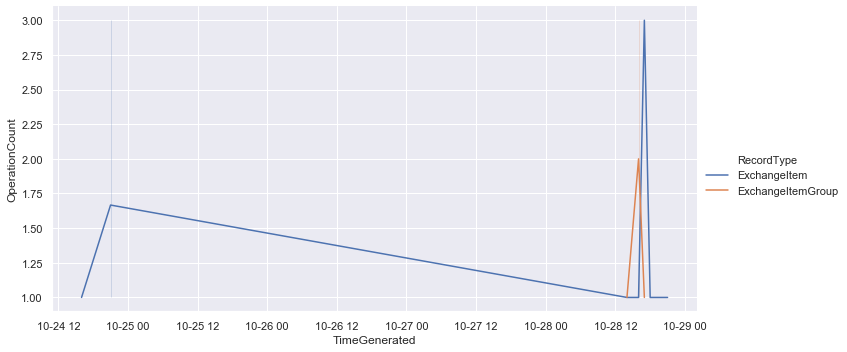

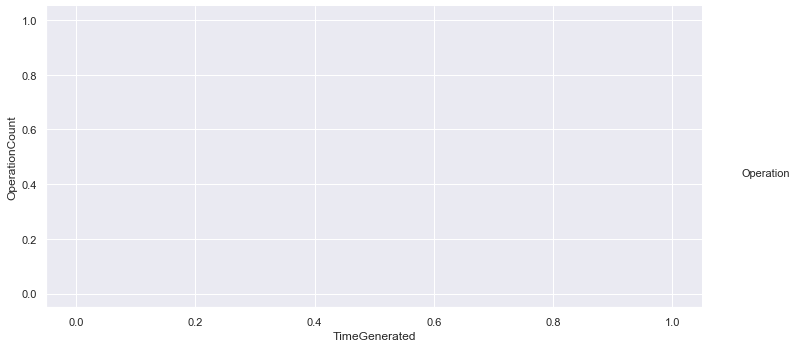

In [29]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    display(Markdown('### Change in rate of Activity Class (RecordType) and Operation'))
    sns.relplot(data=office_ops_summary_df, x='TimeGenerated', y='OperationCount', kind='line', aspect=2, 
                hue='RecordType')
    sns.relplot(data=office_ops_summary_df.query('RecordType == "SharePointFileOperation"'), 
                x='TimeGenerated', y='OperationCount', hue='Operation', kind='line', aspect=2)



<a id='user_activity_counts'></a>[Contents](#contents)
### Users With largest Activity Type Count

### Identify Users/IPs with largest operation count

Operation,MailboxLogin
Account,
brandon,3
heiko,1
skadam,1


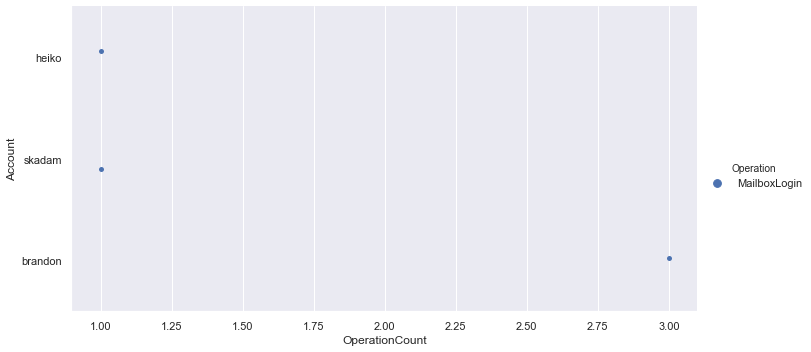

In [30]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    display(Markdown('### Identify Users/IPs with largest operation count'))
    office_ops = office_ops_summary_df.assign(Account=lambda x: 
                                              (x.UserId.str.extract('([^@]+)@.*', expand=False)).str.lower())

    limit_op_types = ['FileDownloaded', 'FileModified','FileUploaded',
                      'MailboxLogin']
    office_ops = office_ops[office_ops.Operation.isin(limit_op_types)]
    
    sns.catplot(data=office_ops, y='Account', x='OperationCount', 
                hue='Operation', aspect=2)
    display(office_ops.pivot_table('OperationCount', index=['Account'], 
                                   columns='Operation').style.bar(color='orange', align='mid'))

In [31]:
new_df = office_ops_df[['OfficeId', 'RecordType', 'TimeGenerated', 'Operation',
       'OrganizationId', 'UserType', 'UserKey', 'OfficeWorkload',
       'ResultStatus', 'OfficeObjectId', 'UserId', 'ClientIP','UserAgent']]
pd.merge(new_df, ip_locs_df, how='left', left_on='ClientIP', right_on='Address')

,OfficeId,RecordType,TimeGenerated,Operation,OrganizationId,UserType,UserKey,OfficeWorkload,ResultStatus,OfficeObjectId,UserId,ClientIP,UserAgent,Address,AdditionalData,Type,CountryCode,CountryName,State,City,Longitude,Latitude
0,de42f868-03a1-4a41-0d8e-08d75bb007d1,ExchangeItem,2019-10-28 14:06:29,Create,12bce6d0-bfeb-4a82-abe6-98ccf3196a11,Regular,10033FFF99CAB5DB,Exchange,Succeeded,,heiko@a830edad9050849NDA3313.onmicrosoft.com,::1,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4cfe574f-9f18-4cf3-121c-08d75bc5fef7,ExchangeItemGroup,2019-10-28 16:43:44,MoveToDeletedItems,12bce6d0-bfeb-4a82-abe6-98ccf3196a11,Regular,10033FFF99CAB5DB,Exchange,Succeeded,,heiko@a830edad9050849NDA3313.onmicrosoft.com,2001:4898:80e8:9:d265:d4d0:4c20:de00,,2001:4898:80e8:9:d265:d4d0:4c20:de00,{},geolocation,US,United States,Washington,Redmond,-122.1243,47.6742
2,5737b62e-a82c-4c81-f372-08d75bc5bc3a,ExchangeItem,2019-10-28 16:41:52,Create,12bce6d0-bfeb-4a82-abe6-98ccf3196a11,Regular,100300008EDE316B,Exchange,Succeeded,,brandon@a830edad9050849NDA3313.onmicrosoft.com,40.121.209.123,,40.121.209.123,{},geolocation,US,United States,Virginia,Washington,-78.1539,38.7095
3,d5faa8f4-8f4f-4e54-e035-08d75bc5ff30,ExchangeItemGroup,2019-10-28 16:43:44,MoveToDeletedItems,12bce6d0-bfeb-4a82-abe6-98ccf3196a11,Regular,10033FFF99CAB5DB,Exchange,Succeeded,,heiko@a830edad9050849NDA3313.onmicrosoft.com,2001:4898:80e8:9:d265:d4d0:4c20:de00,,2001:4898:80e8:9:d265:d4d0:4c20:de00,{},geolocation,US,United States,Washington,Redmond,-122.1243,47.6742
4,f4582d8f-2e56-4190-dca9-08d75bc5bb1c,ExchangeItem,2019-10-28 16:41:50,Create,12bce6d0-bfeb-4a82-abe6-98ccf3196a11,Regular,10033FFF99CAB5DB,Exchange,Succeeded,,heiko@a830edad9050849NDA3313.onmicrosoft.com,40.121.209.123,,40.121.209.123,{},geolocation,US,United States,Virginia,Washington,-78.1539,38.7095
5,af942392-9843-422f-086b-08d75bc5c343,ExchangeItem,2019-10-28 16:42:03,Create,12bce6d0-bfeb-4a82-abe6-98ccf3196a11,Regular,1003BFFD9C881400,Exchange,Succeeded,,brendonb@a830edad9050849NDA3313.onmicrosoft.com,40.121.209.123,,40.121.209.123,{},geolocation,US,United States,Virginia,Washington,-78.1539,38.7095
6,4b2b9e0d-489e-4879-3eac-08d75bc5ba9c,ExchangeItem,2019-10-28 16:41:49,Create,12bce6d0-bfeb-4a82-abe6-98ccf3196a11,Regular,1003BFFD8EC47BAA,Exchange,Succeeded,,admin@a830edad9050849NDA3313.onmicrosoft.com,40.121.209.123,,40.121.209.123,{},geolocation,US,United States,Virginia,Washington,-78.1539,38.7095
7,84e83a0c-0723-410f-9863-08d75bc5c430,ExchangeItem,2019-10-28 16:42:05,Create,12bce6d0-bfeb-4a82-abe6-98ccf3196a11,Regular,1003BFFD9A21CCC2,Exchange,Succeeded,,anthons@a830edad9050849NDA3313.onmicrosoft.com,40.121.209.123,,40.121.209.123,{},geolocation,US,United States,Virginia,Washington,-78.1539,38.7095
8,e4d33c2e-47bd-408a-afe2-08d75bc5bff4,ExchangeItem,2019-10-28 16:41:58,Create,12bce6d0-bfeb-4a82-abe6-98ccf3196a11,Regular,1003BFFD958EBBE9,Exchange,Succeeded,,vantest@a830edad9050849NDA3313.onmicrosoft.com,40.121.209.123,,40.121.209.123,{},geolocation,US,United States,Virginia,Washington,-78.1539,38.7095
9,f34f4d08-e682-432d-b199-08d75bc624b3,ExchangeItemGroup,2019-10-28 16:44:47,MoveToDeletedItems,12bce6d0-bfeb-4a82-abe6-98ccf3196a11,Regular,10033FFF99CAB5DB,Exchange,Succeeded,,heiko@a830edad9050849NDA3313.onmicrosoft.com,2001:4898:80e8:a:d264:d4d0:4c20:de00,,2001:4898:80e8:a:d264:d4d0:4c20:de00,{},geolocation,US,United States,Washington,Redmond,-122.1243,47.6742


<a id='o365_user_inv'></a>[Contents](#contents)
## Office User Investigation

In [33]:
# set the origin time to the time of our alert
o365_query_times_user = nbwidgets.QueryTime(units='days',
                           before=10, after=1, max_before=60, max_after=20, auto_display=True)


HTML(value='<h4>Set query time boundaries</h4>')

In [35]:
distinct_users = office_ops_df[['UserId']].sort_values('UserId')['UserId'].str.lower().drop_duplicates().tolist()
distinct_users
user_select = nbwidgets.SelectString(description='Select User Id', item_list=distinct_users, auto_display=True)
                               # (items=distinct_users)

<a id='user_act_summary'></a>[Contents](#contents)
### Activity Summary

In [39]:
# Provides a summary view of a given account's activity
# For use when investigating an account that has been identified as having associated suspect activity or been otherwise compromised. 
# All office activity by UserName using UI to set Time range
# Tags: #Persistence, #Discovery, #Lateral Movement, #Collection

user_activity_query = '''
OfficeActivity
| where TimeGenerated >= datetime({start})
| where TimeGenerated <= datetime({end})
| where UserKey has "{user}" or UserId has "{user}"
'''
print('Getting data...', end=' ')
o365_query = user_activity_query.format(start=o365_query_times_user.start, 
                                        end=o365_query_times_user.end,
                                        user=user_select.value)
%kql -query o365_query
user_activity_df = _kql_raw_result_.to_dataframe()
print('done.')
user_activity_df

Getting data... done.


,OfficeId,RecordType,TimeGenerated,Operation,OrganizationId,UserType,UserKey,OfficeWorkload,ResultStatus,OfficeObjectId,UserId,ClientIP,Site_,ItemType,EventSource,Source_Name,UserAgent,MachineDomainInfo,MachineId,Site_Url,SourceRelativeUrl,SourceFileName,SourceFileExtension,DestinationRelativeUrl,DestinationFileName,...,Client,LoginStatus,UserDomain,Actor,ActorContextId,ActorIpAddress,InterSystemsId,IntraSystemId,SupportTicketId,AADTarget,TargetContextId,DataCenterSecurityEventType,Start_Time,EffectiveOrganization,ElevationTime,ElevationApprover,ElevationApprovedTime,ElevationRequestId,ElevationRole,ElevationDuration,GenericInfo,TenantId,OfficeTenantId,SourceSystem,Type
0,3a41cf20-3b32-4c26-196a-08d756398597,ExchangeItem,2019-10-21 15:15:35,Create,12bce6d0-bfeb-4a82-abe6-98ccf3196a11,Regular,100300008EDE316B,Exchange,Succeeded,,brandon@a830edad9050849NDA3313.onmicrosoft.com,::1,,,,,,,,,,,,,,...,,NaN,,,,,,,,,,NaN,2019-10-21 16:53:34,,2019-10-21 16:53:34,,NaT,,,NaN,,52b1ab41-869e-4138-9e40-2a4457f09bf0,$RestApiTenantId$,OfficeActivityManager,OfficeActivity
1,5737b62e-a82c-4c81-f372-08d75bc5bc3a,ExchangeItem,2019-10-28 16:41:52,Create,12bce6d0-bfeb-4a82-abe6-98ccf3196a11,Regular,100300008EDE316B,Exchange,Succeeded,,brandon@a830edad9050849NDA3313.onmicrosoft.com,40.121.209.123,,,,,,,,,,,,,,...,,NaN,,,,,,,,,,NaN,2019-10-28 17:13:11,,2019-10-28 17:13:11,,NaT,,,NaN,,52b1ab41-869e-4138-9e40-2a4457f09bf0,$RestApiTenantId$,OfficeActivityManager,OfficeActivity
2,aea2b6c5-9abc-4778-5026-08d75707792e,ExchangeItem,2019-10-22 15:49:50,Create,12bce6d0-bfeb-4a82-abe6-98ccf3196a11,Regular,100300008EDE316B,Exchange,Succeeded,,brandon@a830edad9050849NDA3313.onmicrosoft.com,40.121.209.123,,,,,,,,,,,,,,...,,NaN,,,,,,,,,,NaN,2019-10-23 09:38:58,,2019-10-23 09:38:58,,NaT,,,NaN,,52b1ab41-869e-4138-9e40-2a4457f09bf0,$RestApiTenantId$,OfficeActivityManager,OfficeActivity
3,c7d64c29-8a08-440a-c584-08d758c87518,ExchangeItem,2019-10-24 21:23:47,MailboxLogin,12bce6d0-bfeb-4a82-abe6-98ccf3196a11,Regular,100300008EDE316B,Exchange,Succeeded,,brandon@a830edad9050849NDA3313.onmicrosoft.com,97.113.196.81,,,,,,,,,,,,,,...,,NaN,,,,,,,,,,NaN,2019-10-24 21:53:06,,2019-10-24 21:53:06,,NaT,,,NaN,,52b1ab41-869e-4138-9e40-2a4457f09bf0,$RestApiTenantId$,OfficeActivityManager,OfficeActivity
4,44f3db3b-6b8a-41ac-979c-08d758cd19f7,ExchangeItem,2019-10-24 21:57:02,Create,12bce6d0-bfeb-4a82-abe6-98ccf3196a11,Regular,100300008EDE316B,Exchange,Succeeded,,brandon@a830edad9050849NDA3313.onmicrosoft.com,13.92.135.46,,,,,,,,,,,,,,...,,NaN,,,,,,,,,,NaN,2019-10-24 22:18:53,,2019-10-24 22:18:53,,NaT,,,NaN,,52b1ab41-869e-4138-9e40-2a4457f09bf0,$RestApiTenantId$,OfficeActivityManager,OfficeActivity
5,907d782c-f10d-4e6c-5289-08d758ccd33b,ExchangeItem,2019-10-24 21:55:03,MailboxLogin,12bce6d0-bfeb-4a82-abe6-98ccf3196a11,Regular,100300008EDE316B,Exchange,Succeeded,,brandon@a830edad9050849NDA3313.onmicrosoft.com,97.113.196.81,,,,,,,,,,,,,,...,,NaN,,,,,,,,,,NaN,2019-10-24 22:18:53,,2019-10-24 22:18:53,,NaT,,,NaN,,52b1ab41-869e-4138-9e40-2a4457f09bf0,$RestApiTenantId$,OfficeActivityManager,OfficeActivity
6,eb6da298-2c92-4e93-8d40-08d758c82763,ExchangeItem,2019-10-24 21:21:37,MailboxLogin,12bce6d0-bfeb-4a82-abe6-98ccf3196a11,Regular,100300008EDE316B,Exchange,Succeeded,,brandon@a830edad9050849NDA3313.onmicrosoft.com,97.113.196.81,,,,,,,,,,,,,,...,,NaN,,,,,,,,,,NaN,2019-10-24 21:48:30,,2019-10-24 21:48:30,,NaT,,,NaN,,52b1ab41-869e-4138-9e40-2a4457f09bf0,$RestApiTenantId$,OfficeActivityManager,OfficeActivity


<a id='user_op_count'></a>[Contents](#contents)
### Operation Breakdown for User

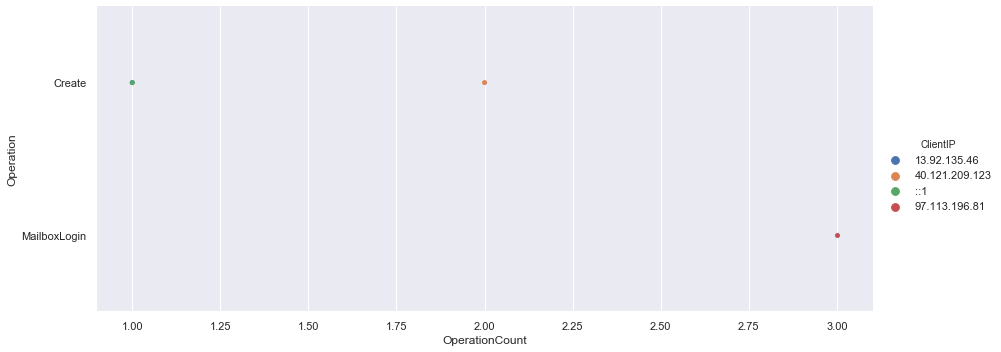

In [40]:
my_df = (user_activity_df[['OfficeId', 'RecordType', 'TimeGenerated', 'Operation',
                           'ResultStatus', 'UserId', 'ClientIP','UserAgent']]
         .groupby(['Operation', 'ResultStatus', 'ClientIP'])
         .aggregate({'OfficeId': 'count'})
         .rename(columns={'OfficeId': 'OperationCount', 'ClientIP': 'IPCount'})
         .reset_index())
sns.catplot(x='OperationCount', y="Operation", hue="ClientIP", jitter=False, data=my_df, aspect=2.5);


<a id='user_ip_counts'></a>[Contents](#contents)
### IP Count for Different User Operations 

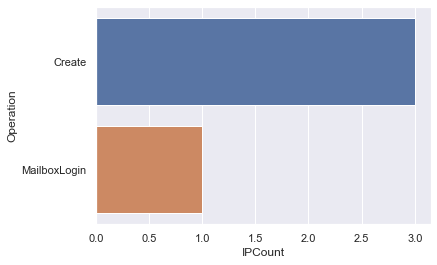

In [41]:
my_df2 = (user_activity_df[['OfficeId', 'RecordType', 'TimeGenerated', 'Operation',
                           'ResultStatus', 'UserId', 'ClientIP','UserAgent']]
         .groupby(['Operation'])
         .aggregate({'OfficeId': 'count', 'ClientIP': 'nunique'})
         .rename(columns={'OfficeId': 'OperationCount', 'ClientIP': 'IPCount'})
         .reset_index())
sns.barplot(x='IPCount', y="Operation", data=my_df2);

<a id='user_act_timeline'></a>[Contents](#contents)
### Activity Timeline

In [42]:
nbdisplay.display_timeline(data=user_activity_df,
                         title='Office Operations',
                         source_columns=['OfficeWorkload', 'Operation', 'ClientIP', 'ResultStatus'],
                         height=200)

Loading BokehJS ...

Figure(id='1004', ...)

<a id='user_geomap'></a>[Contents](#contents)
### User IP GeoMap

In [43]:
def get_row_ip_loc(row):
    try:
        _, ip_entity = iplocation.lookup_ip(ip_address=row.ClientIP)
        return ip_entity
    except ValueError:
        return None
    
from msticpy.nbtools.foliummap import FoliumMap
folium_map = FoliumMap()
off_ip_locs = (user_activity_df[['ClientIP']]
                   .drop_duplicates()
                   .apply(get_row_ip_loc, axis=1)
                   .tolist())
ip_locs = [ip_list[0] for ip_list in off_ip_locs if ip_list]
    
display(HTML('<h3>External IP Addresses seen in Office Activity</h3>'))
display(HTML('Numbered circles indicate multiple items - click to expand.'))


icon_props = {'color': 'purple'}
folium_map.add_ip_cluster(ip_entities=ip_locs,
                          **icon_props)
display(folium_map.folium_map)

<a id='ips_in_azure'></a>[Contents](#contents)
### Check for User IPs in Azure Network Flow Data
The full data is available in the Dataframe ```az_net_query_byip```

In [47]:
if 'AzureNetworkAnalytics_CL' not in table_index:
    display(Markdown('<font color="red"><h2>Warning. Azure network flow data not available.</h2></font><br>'
                     'This section of the notebook is not useable with the current workspace.'))
    
# Azure Network Analytics Base Query
az_net_analytics_query =r'''
AzureNetworkAnalytics_CL 
| where SubType_s == 'FlowLog'
| where FlowStartTime_t >= datetime({start})
| where FlowEndTime_t <= datetime({end})
| project TenantId, TimeGenerated, 
    FlowStartTime = FlowStartTime_t, 
    FlowEndTime = FlowEndTime_t, 
    FlowIntervalEndTime = FlowIntervalEndTime_t, 
    FlowType = FlowType_s,
    ResourceGroup = split(VM_s, '/')[0],
    VMName = split(VM_s, '/')[1],
    VMIPAddress = VMIP_s, 
    PublicIPs = extractall(@"([\d\.]+)[|\d]+", dynamic([1]), PublicIPs_s),
    SrcIP = SrcIP_s,
    DestIP = DestIP_s,
    ExtIP = iif(FlowDirection_s == 'I', SrcIP_s, DestIP_s),
    L4Protocol = L4Protocol_s, 
    L7Protocol = L7Protocol_s, 
    DestPort = DestPort_d, 
    FlowDirection = FlowDirection_s,
    AllowedOutFlows = AllowedOutFlows_d, 
    AllowedInFlows = AllowedInFlows_d,
    DeniedInFlows = DeniedInFlows_d, 
    DeniedOutFlows = DeniedOutFlows_d,
    RemoteRegion = AzureRegion_s,
    VMRegion = Region_s
| extend AllExtIPs = iif(isempty(PublicIPs), pack_array(ExtIP), 
                         iif(isempty(ExtIP), PublicIPs, array_concat(PublicIPs, pack_array(ExtIP)))
                         )
| project-away ExtIP
| mvexpand AllExtIPs
{where_clause}
'''

# Build the query parameters
all_user_ips = user_activity_df['ClientIP'].drop_duplicates().tolist()
all_user_ips = [ip for ip in all_user_ips if ip and ip != '<null>']
ip_list = ','.join(['\'{}\''.format(i) for i in all_user_ips])

az_ip_where = f'''
| where (AllExtIPs in ({ip_list}) 
        or SrcIP in ({ip_list}) 
        or DestIP in ({ip_list}) 
        ) and 
    (AllowedOutFlows > 0 or AllowedInFlows > 0)'''
print('getting data...')
az_net_query_byip = az_net_analytics_query.format(where_clause=az_ip_where,
                                                  start=o365_query_times_user.start,
                                                  end=o365_query_times_user.end)

net_default_cols = ['FlowStartTime', 'FlowEndTime', 'VMName', 'VMIPAddress', 
                'PublicIPs', 'SrcIP', 'DestIP', 'L4Protocol', 'L7Protocol',
                'DestPort', 'FlowDirection', 'AllowedOutFlows', 
                'AllowedInFlows']

%kql -query az_net_query_byip
az_net_comms_df = _kql_raw_result_.to_dataframe()
if az_net_comms_df.empty:
    raise ValueError("No network flow data available in AzureNetworkAnalytics_CL")

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    az_net_comms_df['TotalAllowedFlows'] = az_net_comms_df['AllowedOutFlows'] + az_net_comms_df['AllowedInFlows']
    sns.catplot(x="L7Protocol", y="TotalAllowedFlows", col="FlowDirection", data=az_net_comms_df)
    sns.relplot(x="FlowStartTime", y="TotalAllowedFlows", 
                col="FlowDirection", kind="line", 
                hue="L7Protocol", data=az_net_comms_df).set_xticklabels(rotation=50)

cols = ['VMName', 'VMIPAddress', 'PublicIPs', 'SrcIP', 'DestIP', 'L4Protocol',
        'L7Protocol', 'DestPort', 'FlowDirection', 'AllExtIPs', 'TotalAllowedFlows']
flow_index = az_net_comms_df[cols].copy()
def get_source_ip(row):
    if row.FlowDirection == 'O':
        return row.VMIPAddress if row.VMIPAddress else row.SrcIP
    else:
        return row.AllExtIPs if row.AllExtIPs else row.DestIP
    
def get_dest_ip(row):
    if row.FlowDirection == 'O':
        return row.AllExtIPs if row.AllExtIPs else row.DestIP
    else:
        return row.VMIPAddress if row.VMIPAddress else row.SrcIP

flow_index['source'] = flow_index.apply(get_source_ip, axis=1)
flow_index['target'] = flow_index.apply(get_dest_ip, axis=1)
flow_index['value'] = flow_index['L7Protocol']

cm = sns.light_palette("green", as_cmap=True)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    display(flow_index[['source', 'target', 'value', 'L7Protocol', 
                        'FlowDirection', 'TotalAllowedFlows']]
            .groupby(['source', 'target', 'value', 'L7Protocol', 'FlowDirection'])
            .sum().unstack().style.background_gradient(cmap=cm))

nbdisp.display_timeline(data=az_net_comms_df.query('AllowedOutFlows > 0'),
                         overlay_data=az_net_comms_df.query('AllowedInFlows > 0'),
                         title='Network Flows (out=blue, in=green)',
                         time_column='FlowStartTime',
                         source_columns=['FlowType', 'AllExtIPs', 'L7Protocol', 'FlowDirection'],
                         height=300)

getting data...


ValueError: No network flow data available in AzureNetworkAnalytics_CL

<a id='o365_cluster'></a>[Contents](#contents)
## Rare Combinations of Country/UserAgent/Operation Type
The dataframe below lists combinations in the time period that had less than 3 instances. This might help you to spot relatively unusual activity.

In [50]:

from msticpy.sectools.eventcluster import (dbcluster_events, 
                                           add_process_features, 
                                           char_ord_score,
                                           token_count,
                                           delim_count)

restrict_cols = ['OfficeId', 'RecordType', 'TimeGenerated', 'Operation',
                 'OrganizationId', 'UserType', 'UserKey', 'OfficeWorkload',
                 'ResultStatus', 'OfficeObjectId', 'UserId', 'ClientIP','UserAgent']
feature_office_ops = office_ops_df[restrict_cols]
feature_office_ops = ( pd.merge(feature_office_ops, 
                                ip_locs_df, how='left', 
                                left_on='ClientIP', right_on='Address')
                      .fillna(''))

# feature_office_ops = office_ops_df.copy()

feature_office_ops['country_num'] = feature_office_ops.apply(lambda x: char_ord_score(x.CountryCode) if x.CountryCode else 0, axis=1)
feature_office_ops['ua_tokens'] = feature_office_ops.apply(lambda x: char_ord_score(x.UserAgent), axis=1)
feature_office_ops['user_num'] = feature_office_ops.apply(lambda x: char_ord_score(x.UserId), axis=1)
feature_office_ops['op_num'] = feature_office_ops.apply(lambda x: char_ord_score(x.Operation), axis=1)

# you might need to play around with the max_cluster_distance parameter.
# decreasing this gives more clusters.
(clustered_ops, dbcluster, x_data) = dbcluster_events(data=feature_office_ops,
                                                      cluster_columns=['country_num',
                                                                       'op_num',
                                                                       'ua_tokens'],
                                                      time_column='TimeGenerated',
                                                      max_cluster_distance=0.0001)
print('Number of input events:', len(feature_office_ops))
print('Number of clustered events:', len(clustered_ops))
display(Markdown('#### Rarest combinations'))
display(clustered_ops[['TimeGenerated', 'RecordType',
                        'Operation', 'UserId', 'UserAgent', 'ClusterSize',
                        'OfficeObjectId', 'CountryName']]
    .query('ClusterSize <= 2')
    .sort_values('ClusterSize', ascending=True))
display(Markdown('#### Most common operations'))
display((clustered_ops[['RecordType', 'Operation', 'ClusterSize']]
    .sort_values('ClusterSize', ascending=False)
    .head(10)))

Number of input events: 41
Number of clustered events: 4


#### Rarest combinations

,TimeGenerated,RecordType,Operation,UserId,UserAgent,ClusterSize,OfficeObjectId,CountryName


#### Most common operations

,RecordType,Operation,ClusterSize
2,ExchangeItem,Create,24
1,ExchangeItemGroup,MoveToDeletedItems,6
16,ExchangeItem,MailboxLogin,6
0,ExchangeItem,Create,5


<a id='appendices'></a>[Contents](#contents)
# Appendices

## Available DataFrames

In [ ]:
print('List of current DataFrames in Notebook')
print('-' * 50)
current_vars = list(locals().keys())
for var_name in current_vars:
    if isinstance(locals()[var_name], pd.DataFrame) and not var_name.startswith('_'):
        print(var_name)

## Saving Data to Excel
To save the contents of a pandas DataFrame to an Excel spreadsheet
use the following syntax
```
writer = pd.ExcelWriter('myWorksheet.xlsx')
my_data_frame.to_excel(writer,'Sheet1')
writer.save()
```